In [2]:
import random
import math
from shapely.geometry import LineString
# from intersection import do_intersect
from numba import jit

import numpy as np
class Hypha:
    def __init__(self, base, direction, current_position, speed):
        self.base = base
        self.direction = direction
        self.current_position = current_position
        self.speed = speed
        self.moving = True
        self.angle = 50+10*(random.random()-0.5)
    def length(self):
        length = np.linalg.norm(np.array(self.current_position)-np.array(self.base))
        return(length)
    def move(self, dt, other_hyphae):
        """
        Update the current position of the hypha based on its direction and speed for a given time step.
        Check for intersections with other hyphae and restrict movement if necessary.
        """
        proposed_position = (
            self.current_position[0] + self.direction[0] * self.speed * dt,
            self.current_position[1] + self.direction[1] * self.speed * dt
        )
        for other_hypha in other_hyphae:
            if do_intersect(self.current_position, proposed_position,other_hypha.base, other_hypha.current_position):
                self.moving = False
                return  # Do not move if there's an intersection
        self.current_position = proposed_position
    def branch(self, d=0.001):  # added d as a parameter with default value 1
        """
        Create a new hypha from the current position of this hypha with a 70° angle from its current direction.
        The new branch starts at a distance of 'd' from the current position in the direction of growth.
        """
        angle = math.radians(self.angle) * (1 if random.random() > 0.5 else -1)  # Decide the sign of the angle randomly
        new_direction = (
            self.direction[0] * math.cos(angle) - self.direction[1] * math.sin(angle),
            self.direction[0] * math.sin(angle) + self.direction[1] * math.cos(angle)
        )

        # Calculate the new base for the branching hypha
        new_base = (
            self.current_position[0] + d * new_direction[0],
            self.current_position[1] + d * new_direction[1]
        )

        return Hypha(new_base, new_direction, new_base, self.speed)
class HyphaNetwork:
    def __init__(self, branching_frequency):
        self.hyphae = []
        self.branching_frequency = branching_frequency

    def add_hypha(self, hypha):
        self.hyphae.append(hypha)

    def update_all(self, dt):
        """
        Update the position of all hyphae in the network and decide whether to branch a new hypha.
        """
        new_hyphae = []
        for hypha in self.hyphae:
            if hypha.moving:
                prev_position = hypha.current_position  # Store the previous position
                hypha.move(dt, [other_hypha for other_hypha in self.hyphae if other_hypha != hypha])

                # Check if the hypha moved; if it didn't, skip branching
                if prev_position == hypha.current_position:
                    continue

                if random.random() < self.branching_frequency * dt:
                    new_hypha = hypha.branch()
                    new_hyphae.append(new_hypha)

        self.hyphae.extend(new_hyphae)
        
@jit(nopython=True)
def orientation(p, q, r):
    """ 
    Determine the orientation of an ordered triplet of points in the plane.
    - Returns 0 if the points are colinear.
    - Returns 1 if the points are in clockwise orientation.
    - Returns 2 if the points are in counterclockwise orientation.
    """
    val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
    if val == 0: return 0
    return 1 if val > 0 else 2

@jit(nopython=True)
def on_segment(p, q, r):
    """Check if point q lies on the segment defined by endpoints p and r."""
    return (q[0] <= max(p[0], r[0]) and q[0] >= min(p[0], r[0]) and 
            q[1] <= max(p[1], r[1]) and q[1] >= min(p[1], r[1]))

@jit(nopython=True)
def do_intersect(p1, q1, p2, q2):
    """ 
    Check if line segment p1q1 properly intersects with line segment p2q2.
    """
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)

    if o1 != o2 and o3 != o4:
        return True

    if o1 == 0 and on_segment(p1, p2, q1) and (p1 != p2 and q1 != p2):
        return True
    if o2 == 0 and on_segment(p1, q2, q1) and (p1 != q2 and q1 != q2):
        return True
    if o3 == 0 and on_segment(p2, p1, q2) and (p2 != p1 and q2 != p1):
        return True
    if o4 == 0 and on_segment(p2, q1, q2) and (p2 != q1 and q2 != q1):
        return True

    return False


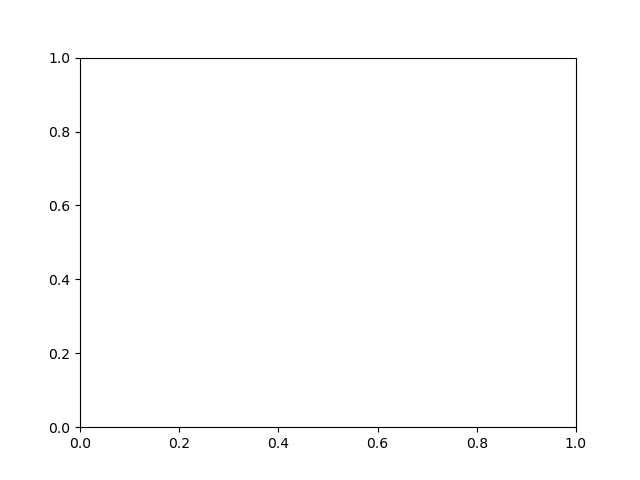

In [3]:
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.animation as animation

class HyphaNetworkVisualizer:
    def __init__(self, network):
        self.network = network
        self.fig, self.ax = plt.subplots()
        self.time_elapsed = 0  # Initialize time
        self.time_text = self.ax.text(0.02, 0.95, '', transform=self.ax.transAxes)  # Position the text on the top-left
        self.ani = animation.FuncAnimation(self.fig, self.update, frames=200, interval=200, repeat=False)
        
    def update(self, frame):
        self.ax.clear()
        self.network.update_all(0.1)  # Updating position with dt=0.1 for demonstration
        for hypha in self.network.hyphae:
            self.ax.plot([hypha.base[0], hypha.current_position[0]], [hypha.base[1], hypha.current_position[1]],alpha = 0.5)
        self.ax.set_xlim([-30, 30])
        self.ax.set_ylim([0, 30])
        self.ax.set_aspect('equal', 'box')
        
        # Update the elapsed time and display it
        self.time_elapsed += 0.05
        self.time_text.set_text(f'Time: {self.time_elapsed:.2f}s')
        self.ax.add_artist(self.time_text)

    def show(self):
        plt.show()
        
# Example usage:
network = HyphaNetwork(1)  # A branching frequency of 0.05 for demonstration
initial_hypha = Hypha((0, 0), (0, 1), (0, 0), 1)  # Starting vertically
network.add_hypha(initial_hypha)
visualizer = HyphaNetworkVisualizer(network)
visualizer.show()


In [3]:
# Example usage:
network = HyphaNetwork(1)  # A branching frequency of 0.05 for demonstration
initial_hypha = Hypha((0, 0), (0, 1), (0, 0), 1)  # Starting vertically
network.add_hypha(initial_hypha)


In [8]:
for i in range(100):
    network.update_all(0.1)

In [27]:
initial_hypha.length()

0.0

In [9]:
lengths = [hypha.length() for hypha in network.hyphae]
lengths = [length for length in lengths if length>0]

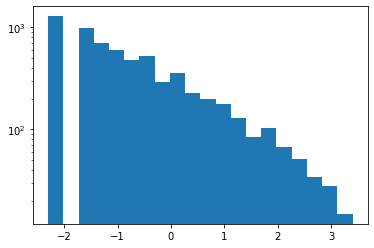

In [11]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.hist(np.log(lengths),20)
ax.set_yscale('log')


In [1]:
import random
import math
from shapely.geometry import LineString
# from intersection import do_intersect
from numba import jit

import numpy as np
class Hypha:
    def __init__(self, base, direction, current_position, speed):
        self.base = base
        self.direction = direction
        self.current_position = current_position
        self.speed = speed
        self.moving = True
        self.angle = 50+10*(random.random()-0.5)
    def length(self):
        length = np.linalg.norm(np.array(self.current_position)-np.array(self.base))
        return(length)
    def move(self, dt, other_hyphae):
        """
        Update the current position of the hypha based on its direction and speed for a given time step.
        Check for intersections with other hyphae and restrict movement if necessary.
        """
        proposed_position = (
            self.current_position[0] + self.direction[0] * self.speed * dt,
            self.current_position[1] + self.direction[1] * self.speed * dt
        )
        for other_hypha in other_hyphae:
            if do_intersect(self.current_position, proposed_position,other_hypha.base, other_hypha.current_position):
                self.moving = False
                return  # Do not move if there's an intersection
        self.current_position = proposed_position
    def branch(self, d=0.001):  # added d as a parameter with default value 1
        """
        Create a new hypha from the current position of this hypha with a 70° angle from its current direction.
        The new branch starts at a distance of 'd' from the current position in the direction of growth.
        """
        angle = math.radians(self.angle) * (1 if random.random() > 0.5 else -1)  # Decide the sign of the angle randomly
        new_direction = (
            self.direction[0] * math.cos(angle) - self.direction[1] * math.sin(angle),
            self.direction[0] * math.sin(angle) + self.direction[1] * math.cos(angle)
        )

        # Calculate the new base for the branching hypha
        new_base = (
            self.current_position[0] + d * new_direction[0],
            self.current_position[1] + d * new_direction[1]
        )

        return Hypha(new_base, new_direction, new_base, self.speed)
class HyphaNetwork:
    def __init__(self, branching_frequency):
        self.hyphae = []
        self.branching_frequency = branching_frequency

    def add_hypha(self, hypha):
        self.hyphae.append(hypha)

    def update_all(self, dt):
        """
        Update the position of all hyphae in the network and decide whether to branch a new hypha.
        """
        new_hyphae = []
        for hypha in self.hyphae:
            if hypha.moving:
                prev_position = hypha.current_position  # Store the previous position
                hypha.move(dt, [other_hypha for other_hypha in self.hyphae if other_hypha != hypha])

                # Check if the hypha moved; if it didn't, skip branching
                if prev_position == hypha.current_position:
                    continue

                if random.random() < self.branching_frequency * dt:
                    new_hypha = hypha.branch()
                    new_hyphae.append(new_hypha)

        self.hyphae.extend(new_hyphae)
        
@jit(nopython=True)
def orientation(p, q, r):
    """ 
    Determine the orientation of an ordered triplet of points in the plane.
    - Returns 0 if the points are colinear.
    - Returns 1 if the points are in clockwise orientation.
    - Returns 2 if the points are in counterclockwise orientation.
    """
    val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
    if val == 0: return 0
    return 1 if val > 0 else 2

@jit(nopython=True)
def on_segment(p, q, r):
    """Check if point q lies on the segment defined by endpoints p and r."""
    return (q[0] <= max(p[0], r[0]) and q[0] >= min(p[0], r[0]) and 
            q[1] <= max(p[1], r[1]) and q[1] >= min(p[1], r[1]))

@jit(nopython=True)
def do_intersect(p1, q1, p2, q2):
    """ 
    Check if line segment p1q1 properly intersects with line segment p2q2.
    """
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)

    if o1 != o2 and o3 != o4:
        return True

    if o1 == 0 and on_segment(p1, p2, q1) and (p1 != p2 and q1 != p2):
        return True
    if o2 == 0 and on_segment(p1, q2, q1) and (p1 != q2 and q1 != q2):
        return True
    if o3 == 0 and on_segment(p2, p1, q2) and (p2 != p1 and q2 != p1):
        return True
    if o4 == 0 and on_segment(p2, q1, q2) and (p2 != q1 and q2 != q1):
        return True

    return False


0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


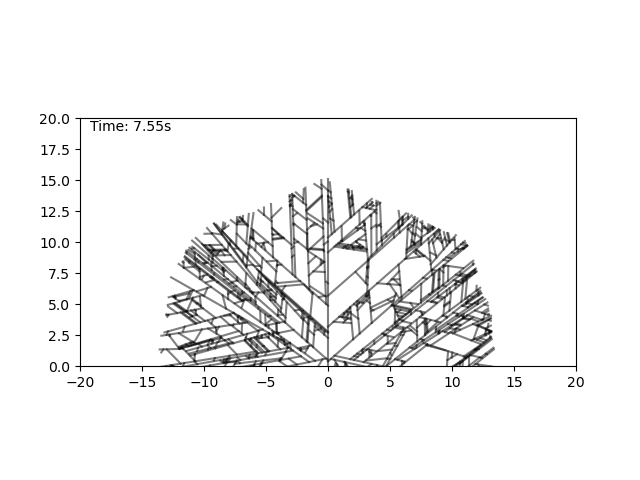

In [2]:
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.animation as animation

class HyphaNetworkVisualizer:
    def __init__(self, network):
        self.network = network
        self.fig, self.ax = plt.subplots()
        self.time_elapsed = 0  # Initialize time
        self.time_text = self.ax.text(0.02, 0.95, '', transform=self.ax.transAxes)  # Position the text on the top-left
        self.ani = animation.FuncAnimation(self.fig, self.update, frames=150, interval=200, repeat=False)
        
    def update(self, frame):
        print(frame)
        self.ax.clear()
        self.network.update_all(0.1)  # Updating position with dt=0.1 for demonstration
        for hypha in self.network.hyphae:
            self.ax.plot([hypha.base[0], hypha.current_position[0]], [hypha.base[1], hypha.current_position[1]],alpha = 0.5,color="black")
        self.ax.set_xlim([-20, 20])
        self.ax.set_ylim([0, 20])
        self.ax.set_aspect('equal', 'box')
        
        # Update the elapsed time and display it
        self.time_elapsed += 0.05
        self.time_text.set_text(f'Time: {self.time_elapsed:.2f}s')
        self.ax.add_artist(self.time_text)
    def save_animation(self, filename):
        self.ani.save(filename, writer='ffmpeg', fps=5)
    def show(self):
        plt.show()
        
# Example usage:
network = HyphaNetwork(1)  # A branching frequency of 0.05 for demonstration
initial_hypha = Hypha((0, 0), (0, 1), (0, 0), 1)  # Starting vertically
network.add_hypha(initial_hypha)
visualizer = HyphaNetworkVisualizer(network)
visualizer.save_animation("no_anas_black.mp4")